In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
from tqdm import tqdm

In [94]:
new_df = pd.read_csv('new_df_10.csv')

In [95]:
# read unique_types.csv into a list
unique_types = pd.read_csv('unique_types.csv')
unique_types = unique_types['type'].tolist()
print(len(unique_types))
# # delete the unique_types columns in new_df if the number of the type is less than 100 that not 0
# for col in unique_types:
#     if (new_df[col] != 0).sum() < 500:
#         new_df = new_df.drop(columns=[col])
#         # delete the type in the list
#         unique_types.remove(col)
        
print(f"Number of columns left for unique_types: {len(unique_types)}")

36
Number of columns left for unique_types: 36


In [96]:
# Calculate the frequency of the number 0 across all unique_types columns
zero_count = (new_df[unique_types] == 0).sum().sum()

# Calculate the total count of all numbers in unique_types columns
total_count = len(new_df) * len(unique_types)

# Calculate the overall percentage of the number 0
zero_percentage = (zero_count / total_count) * 100

# Print the percentage of the number 0
print(f"Percentage of 0: {zero_percentage:.2f}%")

Percentage of 0: 71.91%


In [97]:
for col in unique_types:
    if new_df[col].quantile(0.999) < new_df[col].max():
        new_df.loc[new_df[col] > new_df[col].quantile(0.999), col] = new_df[col].quantile(0.999)
    

In [98]:
zero_frequencies = (new_df[unique_types] == 0).sum() / len(new_df)

# >90% columns with 0
columns_to_drop = zero_frequencies[zero_frequencies > 0.9].index

# Drop the columns
new_df.drop(columns=columns_to_drop, inplace=True)

# Print the columns that were dropped
print(f"Deleted columns: {list(columns_to_drop)}")

Deleted columns: ['Noise - Commercial - Car/Truck Horn', 'Noise - Noise: Private Carting Noise (NQ1)', 'Noise - Noise, Other Animals (NR6)', 'Noise - House of Worship - Loud Music/Party', 'Noise - Commercial - Loud Television', 'Noise - Helicopter - NYPD', 'Collection Truck Noise - 21 Collection Truck Noise', 'Noise - Park - Loud Talking', 'Noise - Noise: Boat(Engine,Music,Etc) (NR10)', 'Noise - Noise: Manufacturing Noise (NK1)', 'Noise - House of Worship - Loud Talking', 'Noise - Helicopter - News Gathering', 'Noise - House of Worship - Banging/Pounding']


In [99]:
# delete the name of the columns that were dropped from the unique_types list
for col in columns_to_drop:
    unique_types.remove(col)

In [100]:
len(unique_types)

23

In [101]:
new_df[unique_types].describe()

,Noise - Park - Loud Music/Party,Noise - Residential - Loud Music/Party,Noise - Street/Sidewalk - Loud Talking,Noise - Vehicle - Car/Truck Music,Noise - Helicopter - Other,Noise - Residential - Banging/Pounding,Noise - Street/Sidewalk - Loud Music/Party,Noise - Commercial - Loud Music/Party,Noise - Commercial - Loud Talking,Noise - Residential - Loud Talking,...,"Noise - Noise, Barking Dog (NR5)",Noise - Noise: Jack Hammering (NC2),Noise - Residential - Loud Television,Noise - Vehicle - Engine Idling,Noise - Noise: Construction Equipment (NC1),Noise - Noise: Alarms (NR3),Noise - Noise: air condition/ventilation equipment (NV1),Noise - Noise: lawn care equipment (NCL),Noise - Commercial - Car/Truck Music,"Noise - Noise, Ice Cream Truck (NR4)"
count,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,...,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000
mean,1.788230,57.396531,7.576893,12.643075,5.985579,26.817387,43.020458,13.231727,1.114431,6.477044,...,2.005873,0.719958,1.477687,3.236569,2.246923,1.121534,1.186116,0.279926,0.571909,0.439295
std,13.549313,103.461124,26.192779,47.298975,74.223811,84.105368,140.342288,52.058697,5.809202,20.524680,...,4.867443,2.348644,6.264202,11.785417,5.671095,2.426098,4.274766,1.161925,2.656498,1.950542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,18.000000,1.000000,1.000000,0.000000,4.000000,5.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,64.000000,5.000000,7.000000,0.000000,19.000000,23.000000,3.000000,0.000000,6.000000,...,2.000000,0.000000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,296.112000,1117.344000,426.639000,699.307000,1818.904000,1353.419000,1909.892000,723.112000,96.556000,362.834000,...,62.639000,31.000000,108.639000,223.448000,67.639000,23.000000,54.195000,17.639000,45.917000,29.278000


In [102]:
def calculate_weighted_boundaries_4_classes(df, unique_types):
    boundaries_per_dataset = []

    # Step 1: Calculate total complaint count per row
    df['total_complaint_count'] = df[unique_types].sum(axis=1)
    
    # Step 2: Calculate 4 quantile boundaries based on the total complaint count
    total_boundaries = {
        0: 0,  # No complaints
        1: df['total_complaint_count'].quantile(0.05),  # Low complaints
        2: df['total_complaint_count'].quantile(0.5),   # Moderate complaints
        3: df['total_complaint_count'].quantile(0.8)   # High complaints
    }

    # Step 3: Calculate weights for each unique_types column (e.g., based on mean or sum)
    column_weights = {col: df[col].mean() for col in unique_types}  # Example: use mean as weight

    # Initialize dictionary to store adjusted boundaries for each column
    boundaries_per_type = {}

    # Step 4: Adjust boundaries for each unique_types column based on weights
    for col in unique_types:
        # Use the total boundaries scaled by the weight of the column
        col_weight = column_weights[col]
        max_weight = max(column_weights.values())
        boundaries_per_type[col] = {
            level: total_boundaries[level] * col_weight / max_weight
            for level in total_boundaries
        }

    # Append boundaries for the current dataset to the list
    boundaries_per_dataset.append(boundaries_per_type)
    
    return boundaries_per_dataset

# Function to categorize values in unique_types columns based on weighted boundaries
def apply_weighted_boundaries_4_classes(df, unique_types, boundaries):
    def categorize(value, col_boundaries):
        # Assign category based on adjusted boundaries for 4 classes
        for category in range(3):
            if col_boundaries[category] <= value < col_boundaries[category + 1]:
                return category
        return 3  # Assign the highest category if the value is above the last boundary

    for col in unique_types:
        col_boundaries = boundaries[col]  # Get specific boundaries for the current column
        df[col] = df[col].apply(lambda x: categorize(x, col_boundaries))

# Example usage
boundaries_per_dataset = calculate_weighted_boundaries_4_classes(new_df, unique_types)  # Calculate weighted boundaries with 4 classes

apply_weighted_boundaries_4_classes(new_df, unique_types, boundaries_per_dataset[0])


In [103]:
new_df

,h3_index,density,stripclub,sports_centre,gatehouse,block,beauty_school,data_center,Noise - Noise: Construction Before/After Hours (NM1),crossing,...,peninsula,industrial,carport,music,bowling,public_bookcase,dog_toilet,summer_camp,Noise - Vehicle - Car/Truck Music,total_complaint_count
0,8af05aa41747fff,0.000000e+00,0,0,0,0,0,0,1,11,...,0,0,0,0,0,0,0,0,0,85.0
1,8af05aa65a07fff,2.627205e+06,0,0,0,0,0,0,1,11,...,0,0,0,0,0,0,0,0,1,176.0
2,8af05ab4c75ffff,0.000000e+00,0,0,0,0,0,0,2,22,...,0,0,0,0,0,0,0,0,3,509.0
3,8af05aa44cd7fff,2.064071e+06,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,1,274.0
4,8af05ab4b08ffff,0.000000e+00,0,0,0,0,0,0,1,12,...,0,0,0,0,0,0,0,0,2,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15357,8af05aa46327fff,6.897379e+03,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
15358,8af0587940f7fff,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
15359,8af0587b4717fff,0.000000e+00,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
15360,8af05bda44a7fff,2.251097e+03,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0


In [104]:
new_df[unique_types].describe()

,Noise - Park - Loud Music/Party,Noise - Residential - Loud Music/Party,Noise - Street/Sidewalk - Loud Talking,Noise - Vehicle - Car/Truck Music,Noise - Helicopter - Other,Noise - Residential - Banging/Pounding,Noise - Street/Sidewalk - Loud Music/Party,Noise - Commercial - Loud Music/Party,Noise - Commercial - Loud Talking,Noise - Residential - Loud Talking,...,"Noise - Noise, Barking Dog (NR5)",Noise - Noise: Jack Hammering (NC2),Noise - Residential - Loud Television,Noise - Vehicle - Engine Idling,Noise - Noise: Construction Equipment (NC1),Noise - Noise: Alarms (NR3),Noise - Noise: air condition/ventilation equipment (NV1),Noise - Noise: lawn care equipment (NCL),Noise - Commercial - Car/Truck Music,"Noise - Noise, Ice Cream Truck (NR4)"
count,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,...,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000,15362.000000
mean,0.309660,1.149004,0.810441,0.855227,0.222041,1.004687,0.938029,0.616261,0.323265,0.888101,...,0.688127,0.529488,0.487437,0.771058,0.722562,0.627913,0.424880,0.314152,0.389923,0.321963
std,0.748235,0.733827,0.848224,0.792436,0.570161,0.757561,0.770147,0.854146,0.772832,0.839842,...,0.918912,0.969126,0.890096,0.845065,0.908393,0.937093,0.868692,0.820126,0.889887,0.821857
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [105]:
# Calculate the frequency of each number (0, 1, 2, 3) across all unique_types columns
number_counts = {num: (new_df[unique_types] == num).sum().sum() for num in range(4)}

# Calculate the total count of all numbers in unique_types columns
total_count = len(new_df) * len(unique_types)

# Calculate the overall percentage for each number
overall_percentages = {num: (count / total_count) * 100 for num, count in number_counts.items()}

# Print the percentage of each number
for num, percentage in overall_percentages.items():
    print(f"Number {num}: {percentage:.2f}%")


Number 0: 59.21%
Number 1: 23.48%
Number 2: 12.68%
Number 3: 4.62%


## Build a model

### RandomForest

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm  # For displaying progress bar
import matplotlib.pyplot as plt

In [107]:
# Separate features and target
X = new_df.drop(columns=["h3_index"] + unique_types)  # Features (excluding 'h3_index' and target columns)
y = new_df[unique_types]  # Multi-column target variables (each column is a 4-class target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [108]:
# Step 3: Variance Threshold - removing features with low variance
# Only features with variance above the threshold will be kept
var_thresh = VarianceThreshold(threshold=0.1)
X_train = var_thresh.fit_transform(X_train)
X_test = var_thresh.transform(X_test)  # Apply the same transformation to test data

print("Features after variance threshold:", X_train.shape[1])

Features after variance threshold: 439


In [109]:
 X_train.shape

(12289, 439)

In [110]:
# Step 4: Model-based Feature Selection using RandomForestClassifier
# Initialize RandomForest to estimate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=46)
model.fit(X_train, y_train)

# Select features with importance greater than the mean importance
selector = SelectFromModel(model, threshold="mean")
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)  # Apply the same selection to test data

print("Features after model-based selection:", X_train.shape[1])

Features after model-based selection: 70


In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Initialize a list to store Dummy models for each column
dummy_models = []
y_test_pred_dummy = []

# Train a separate DummyClassifier for each column in y
for col in range(y_train.shape[1]):
    # Initialize DummyClassifier with "most_frequent" strategy for each column
    dummy_model = DummyClassifier(strategy="most_frequent")
    dummy_model.fit(X_train, y_train.iloc[:, col])  # Train on each column
    dummy_models.append(dummy_model)
    
    # Make predictions for the test set on each column
    y_test_pred_dummy.append(dummy_model.predict(X_test))

# Stack predictions horizontally to match y_test structure
y_test_pred_dummy = np.column_stack(y_test_pred_dummy)

# Calculate and print the overall test accuracy
dummy_column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_dummy[:, col]) for col in range(y_test.shape[1])
]
overall_dummy_acc = np.mean(dummy_column_accuracies)
print("Baseline (Dummy Classifier) Test Accuracy:", overall_dummy_acc)

# Compute and display the combined confusion matrix for all columns
# Flatten y_test and y_test_pred_dummy for an overall confusion matrix across all columns
y_test_combined_dummy = y_test.values.ravel()
y_test_pred_combined_dummy = y_test_pred_dummy.ravel()
cm_dummy = confusion_matrix(y_test_combined_dummy, y_test_pred_combined_dummy)
print("Baseline (Dummy Classifier) Overall Confusion Matrix:\n", cm_dummy)

# Calculate and print the accuracy for each class in the baseline model
class_accuracies_dummy = cm_dummy.diagonal() / cm_dummy.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_dummy):
    print(f"Accuracy for class {i} in Baseline Model (Dummy Classifier): {accuracy:.2%}")


Baseline (Dummy Classifier) Test Accuracy: 0.6413927757891311
Baseline (Dummy Classifier) Overall Confusion Matrix:
 [[36392  5589     0     0]
 [ 7383  8941     0     0]
 [ 5999  3044     0     0]
 [ 2467   864     0     0]]
Accuracy for class 0 in Baseline Model (Dummy Classifier): 86.69%
Accuracy for class 1 in Baseline Model (Dummy Classifier): 54.77%
Accuracy for class 2 in Baseline Model (Dummy Classifier): 0.00%
Accuracy for class 3 in Baseline Model (Dummy Classifier): 0.00%


In [18]:
# # Step 5: PCA for dimensionality reduction
# # Use PCA to retain components explaining at least 90% of the variance
# pca = PCA(n_components=0.9)  # Retain enough components to explain 90% of the variance
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print("Features after PCA reduction:", X_train.shape[1])

In [31]:
# Step 6: Train separate RandomForestClassifier for each target column
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

# Assuming X and y are already defined as the full dataset and target variables
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=46)

# Initialize lists to store training and validation losses and accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [],[]
models = []  # List to hold models for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_train_losses, column_val_losses = [], []
    column_train_accuracies, column_val_accuracies = [],[]
    column_models = []

    for col in range(y_train.shape[1]):
        # Initialize RandomForestClassifier with incremental trees
        model = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_split=5, random_state=46, n_jobs=-1)
        model.fit(X_train, y_train.iloc[:, col])

        # Predict on training data and validation data for the current column
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate log loss and accuracy for the current column
        train_loss = log_loss(y_train.iloc[:, col], model.predict_proba(X_train))
        val_loss = log_loss(y_val.iloc[:, col], model.predict_proba(X_val))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        val_acc = accuracy_score(y_val.iloc[:, col], y_val_pred)

        # Append column results
        column_train_losses.append(train_loss)
        column_val_losses.append(val_loss)
        column_train_accuracies.append(train_acc)
        column_val_accuracies.append(val_acc)
        column_models.append(model)
    
    # Average the log loss and accuracy across all columns
    avg_train_loss = np.mean(column_train_losses)
    avg_val_loss = np.mean(column_val_losses)
    avg_train_acc = np.mean(column_train_accuracies)
    avg_val_acc = np.mean(column_val_accuracies)
    
    # Append average losses and accuracies to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)
    models = column_models  # Update models with the latest trained models for each column

    # Early stopping condition:
    # 1. Check if the average loss reduction of the last 5 rounds is below threshold
    # 2. Check if the average accuracy improvement of the last 5 rounds is below threshold
    if i > 10:
        train_loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        train_acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        
        val_loss_drops = [val_losses[-j] - val_losses[-j-1] for j in range(1, 6)]
        val_acc_improvements = [val_accuracies[-j] - val_accuracies[-j-1] for j in range(1, 6)]
        
        # Check both training and validation conditions
        if (
            all(drop < 0.0001 for drop in train_loss_drops) or
            all(improvement < 0.0001 for improvement in train_acc_improvements) or
            all(drop < 0.0001 for drop in val_loss_drops) or
            all(improvement < 0.0001 for improvement in val_acc_improvements)
        ):
            print(f"Early stopping at iteration {i}")
            break


Training Progress:  12%|█▏        | 12/100 [02:56<21:32, 14.69s/it]


KeyboardInterrupt: 

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation (test) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Initialize lists to store training and testing losses, accuracies, and cross-entropy losses
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_cross_entropies, test_cross_entropies = [], []
models = []  # List to hold models for each target column

# Set a fixed number of trees for the baseline RandomForest
n_estimators = 100  # 固定树数

# Train a separate RandomForest model for each target column
for col in range(y_train.shape[1]):
    # Initialize RandomForestClassifier with fixed trees
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, min_samples_split=5, random_state=46, n_jobs=-1)
    model.fit(X_train, y_train.iloc[:, col])

    # Predict on training and testing data for the current column
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Predict probabilities for cross-entropy calculation
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Calculate RMSE, accuracy, and cross-entropy for the current column
    train_loss = np.sqrt(mean_squared_error(y_train.iloc[:, col], y_train_pred))
    test_loss = np.sqrt(mean_squared_error(y_test.iloc[:, col], y_test_pred))
    train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
    test_acc = accuracy_score(y_test.iloc[:, col], y_test_pred)
    train_cross_entropy = log_loss(y_train.iloc[:, col], y_train_proba)
    test_cross_entropy = log_loss(y_test.iloc[:, col], y_test_proba)

    # Append column results to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    train_cross_entropies.append(train_cross_entropy)
    test_cross_entropies.append(test_cross_entropy)
    models.append(model)

    # Print accuracy and cross-entropy for the current column
    print(f"Accuracy for column {col} on the test set: {test_acc:.2%}")
    print(f"Cross-Entropy Loss for column {col} on the test set: {test_cross_entropy:.4f}")

# Calculate and print average accuracy, loss, and cross-entropy across all columns
overall_test_accuracy = np.mean(test_accuracies)
overall_test_loss = np.mean(test_losses)
overall_test_cross_entropy = np.mean(test_cross_entropies)
print("\nAverage Test Accuracy across all columns:", overall_test_accuracy)
print("Average Test RMSE across all columns:", overall_test_loss)
print("Average Test Cross-Entropy Loss across all columns:", overall_test_cross_entropy)


Accuracy for column 0 on the test set: 83.24%
Cross-Entropy Loss for column 0 on the test set: 0.5417
Accuracy for column 1 on the test set: 68.34%
Cross-Entropy Loss for column 1 on the test set: 0.7514
Accuracy for column 2 on the test set: 62.94%
Cross-Entropy Loss for column 2 on the test set: 0.8584
Accuracy for column 3 on the test set: 63.10%
Cross-Entropy Loss for column 3 on the test set: 0.8750
Accuracy for column 4 on the test set: 84.58%
Cross-Entropy Loss for column 4 on the test set: 0.4496
Accuracy for column 5 on the test set: 65.54%
Cross-Entropy Loss for column 5 on the test set: 0.8254
Accuracy for column 6 on the test set: 66.25%
Cross-Entropy Loss for column 6 on the test set: 0.7956
Accuracy for column 7 on the test set: 66.22%
Cross-Entropy Loss for column 7 on the test set: 0.7838
Accuracy for column 8 on the test set: 83.79%
Cross-Entropy Loss for column 8 on the test set: 0.4939
Accuracy for column 9 on the test set: 61.57%
Cross-Entropy Loss for column 9 on t

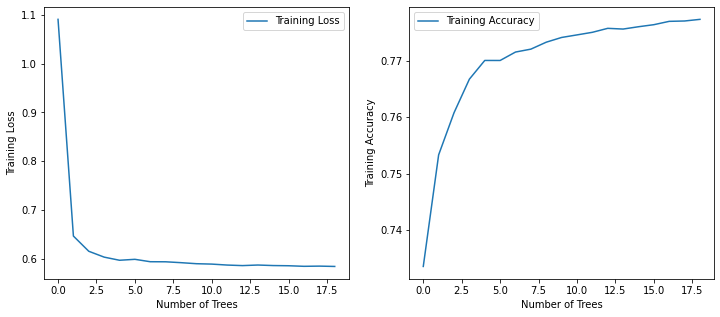

In [20]:
# Plotting the training loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Training Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

In [21]:
# Step 7: Evaluate on the test set
# Make predictions on test data for each model and column
y_test_pred = np.column_stack([model.predict(X_test) for model in models])

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy:", overall_test_acc)

# Compute and display the overall confusion matrix
# Flatten y_test and y_test_pred for a combined confusion matrix across all columns
y_test_combined = y_test.values.ravel()
y_test_pred_combined = y_test_pred.ravel()
cm = confusion_matrix(y_test_combined, y_test_pred_combined)
print("Overall Confusion Matrix:\n", cm)

# # Compute and display the confusion matrix for each label
# for i, col in enumerate(y_test.columns):
#     cm = confusion_matrix(y_test.iloc[:, i], y_test_pred[:, i])
#     print(f"Confusion Matrix for column {col}:\n", cm)


Overall Test Accuracy: 0.7231992529605682
Overall Confusion Matrix:
 [[38789  2760   396    36]
 [ 6132  9238   907    47]
 [ 3711  2599  2482   251]
 [ 1151   518  1056   606]]


In [22]:


# Make predictions on test data for each model and column
y_test_pred_rf = np.column_stack([model.predict(X_test) for model in models])

# Compute and display the overall confusion matrix for Random Forest
y_test_combined_rf = y_test.values.ravel()
y_test_pred_combined_rf = y_test_pred_rf.ravel()
cm_rf = confusion_matrix(y_test_combined_rf, y_test_pred_combined_rf)

# Calculate and print the accuracy for each class
class_accuracies_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_rf):
    print(f"Accuracy for class {i} in Random Forest: {accuracy:.2%}")

Accuracy for class 0 in Random Forest: 92.40%
Accuracy for class 1 in Random Forest: 56.59%
Accuracy for class 2 in Random Forest: 27.45%
Accuracy for class 3 in Random Forest: 18.19%


Training Progress:  60%|██████    | 60/100 [3:24:55<2:16:36, 204.92s/it]

Early stopping at iteration 61


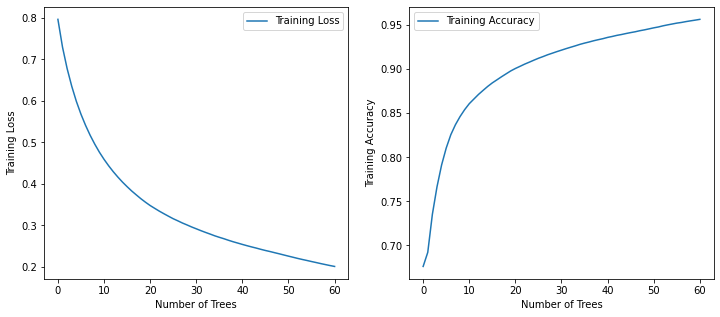

Accuracy for class 0 in GBDT: 89.78%
Accuracy for class 1 in GBDT: 55.92%
Accuracy for class 2 in GBDT: 36.97%
Accuracy for class 3 in GBDT: 31.70%
Overall Test Accuracy with GBDT: 0.7246423973174493
Overall Confusion Matrix with GBDT:
 [[37689  3263   863   166]
 [ 5518  9129  1501   176]
 [ 2911  2136  3343   653]
 [  818   295  1162  1056]]


In [31]:
from sklearn.ensemble import GradientBoostingClassifier  # Import GBDT model2
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tqdm import tqdm  # For displaying progress bar
import matplotlib.pyplot as plt
import numpy as np  # Ensure np is imported

# Initialize lists to store training losses and accuracies
train_losses = []
train_accuracies = []
model2s = []  # List to hold models for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_losses = []
    column_accuracies = []
    column_model2s = []

    for col in range(y_train.shape[1]):
        # Initialize GradientBoostingClassifier (GBDT) with incremental estimators
        model2 = GradientBoostingClassifier(n_estimators=i, max_depth=10, min_samples_split=5, random_state=46)
        model2.fit(X_train, y_train.iloc[:, col])

        # Predict on training data for current column
        y_train_pred = model2.predict(X_train)
        
        # Calculate log loss and accuracy for the current column
        train_loss = log_loss(y_train.iloc[:, col], model2.predict_proba(X_train))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        
        # Append column results
        column_losses.append(train_loss)
        column_accuracies.append(train_acc)
        column_model2s.append(model2)
    
    # Average the log loss and accuracy across all columns
    avg_train_loss = np.mean(column_losses)
    avg_train_acc = np.mean(column_accuracies)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    model2s = column_model2s  # Update model2s with the latest trained model2s for each column

    # Early stopping condition:
    # 1. Check if the average loss reduction of the last 5 rounds is below threshold
    # 2. Check if the average accuracy improvement of the last 5 rounds is below threshold
    if i > 5:
        loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        if all(drop < 0.001 for drop in loss_drops) and all(improvement < 0.001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

# Plotting the training loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Training Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

# Step 7: Evaluate on the test set

# Make predictions on test data for each model2 and column
y_test_pred_gbdt = np.column_stack([model2.predict(X_test) for model2 in model2s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in GBDT: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with GBDT:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with GBDT:\n", cm_gbdt)


In [20]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Split the data into training and validation sets
# Assume X_train and X_test, y_train and y_test are already defined
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=46)

# Initialize lists to store training and validation losses and accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
model3s = []  # List to hold models for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_train_losses, column_val_losses = [], []
    column_train_accuracies, column_val_accuracies = [], []
    column_model3s = []

    for col in range(y_train.shape[1]):
        # Initialize LightGBM model with GPU support
        model3 = LGBMClassifier(
            n_estimators=i,
            max_depth=10,
            learning_rate=0.1,
            min_child_samples=5,
            random_state=46,
            device='gpu',
            gpu_platform_id=1, 
            gpu_device_id=0, 
            verbose=-1
        )
        # Fit model on training data for the current column
        model3.fit(X_train, y_train.iloc[:, col])

        # Predict on training data and validation data for current column
        y_train_pred = model3.predict(X_train)
        y_val_pred = model3.predict(X_val)

        # Calculate log loss and accuracy for training and validation sets
        train_loss = log_loss(y_train.iloc[:, col], model3.predict_proba(X_train))
        val_loss = log_loss(y_val.iloc[:, col], model3.predict_proba(X_val))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        val_acc = accuracy_score(y_val.iloc[:, col], y_val_pred)

        # Append results for the current column
        column_train_losses.append(train_loss)
        column_val_losses.append(val_loss)
        column_train_accuracies.append(train_acc)
        column_val_accuracies.append(val_acc)
        column_model3s.append(model3)

    # Average log loss and accuracy across all columns
    avg_train_loss = np.mean(column_train_losses)
    avg_val_loss = np.mean(column_val_losses)
    avg_train_acc = np.mean(column_train_accuracies)
    avg_val_acc = np.mean(column_val_accuracies)

    # Append average losses and accuracies to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    # Update models with the latest trained models for each column
    model3s = column_model3s

    # Early stopping condition based on last 5 iterations
    if i > 5:
        loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        if all(drop < 0.001 for drop in loss_drops) and all(improvement < 0.001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break



Training Progress:  85%|████████▌ | 85/100 [45:57<08:06, 32.44s/it]

Early stopping at iteration 86


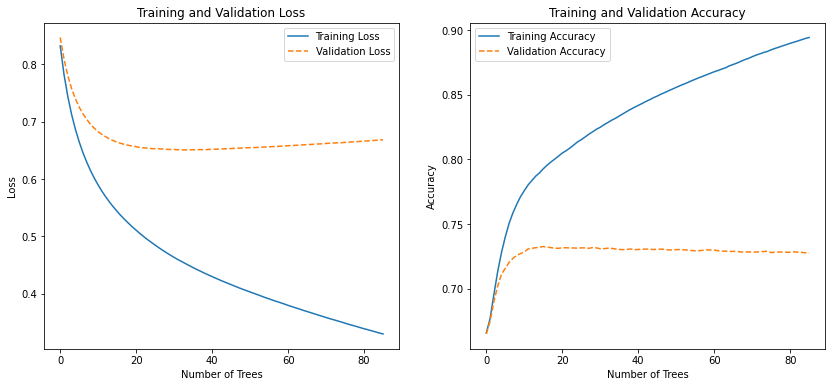

Accuracy for class 0 in GBDT: 90.58%
Accuracy for class 1 in GBDT: 55.45%
Accuracy for class 2 in GBDT: 36.80%
Accuracy for class 3 in GBDT: 33.05%
Overall Test Accuracy with GBDT: 0.7287596032767867
Overall Confusion Matrix with GBDT:
 [[38028  3009   794   150]
 [ 5614  9051  1513   146]
 [ 3002  2078  3328   635]
 [  813   260  1157  1101]]


In [21]:
# Plotting training and validation loss and accuracy curves
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


# Step 7: Evaluate on the test set

# Make predictions on test data for each model3 and column
y_test_pred_gbdt = np.column_stack([model3.predict(X_test) for model3 in model3s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in GBDT: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with GBDT:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with GBDT:\n", cm_gbdt)

In [58]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Split the data into training and validation sets
# Assume X_train and X_test, y_train and y_test are already defined
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=46)

# Initialize lists to store training and validation losses and accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_model3s = []  # List to hold the best models for each target column
best_iteration = 0
best_val_loss = float("inf")  # Track the best validation loss across iterations

# Training loop with early stopping based on the last 10 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_train_losses, column_val_losses = [], []
    column_train_accuracies, column_val_accuracies = [], []
    column_model3s = []

    for col in range(y_train.shape[1]):
        # Initialize LightGBM model with GPU support
        model3 = LGBMClassifier(
            n_estimators=i,
            max_depth=10,
            learning_rate=0.1,
            min_child_samples=5,
            random_state=46,
            device='gpu',
            gpu_platform_id=1, 
            gpu_device_id=0, 
            verbose=-1
        )
        # Fit model on training data for the current column
        model3.fit(X_train, y_train.iloc[:, col])

        # Predict on training data and validation data for current column
        y_train_pred = model3.predict(X_train)
        y_val_pred = model3.predict(X_val)

        # Calculate RMSE and accuracy for training and validation sets
        train_loss = np.sqrt(mean_squared_error(y_train.iloc[:, col], y_train_pred))
        val_loss = np.sqrt(mean_squared_error(y_val.iloc[:, col], y_val_pred))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        val_acc = accuracy_score(y_val.iloc[:, col], y_val_pred)

        # Append results for the current column
        column_train_losses.append(train_loss)
        column_val_losses.append(val_loss)
        column_train_accuracies.append(train_acc)
        column_val_accuracies.append(val_acc)
        column_model3s.append(model3)

    # Average RMSE and accuracy across all columns
    avg_train_loss = np.mean(column_train_losses)
    avg_val_loss = np.mean(column_val_losses)
    avg_train_acc = np.mean(column_train_accuracies)
    avg_val_acc = np.mean(column_val_accuracies)

    # Append average losses and accuracies to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    # Update the best model if current validation loss is the lowest
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model3s = column_model3s  # Store the models for each column at this iteration
        best_iteration = i

    # Early stopping condition based on last 10 iterations
    if i > 20:
        loss_drops = [val_losses[-j] - val_losses[-j-1] for j in range(1, 11)]
        acc_improvements = [val_accuracies[-j] - val_accuracies[-j-1] for j in range(1, 11)]
        
        # Check if loss decreases are all less than 0.001 and accuracy increases are all less than 0.001
        if all(drop < 0.0001 for drop in loss_drops) or all(improvement < 0.0001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

# After early stopping, print the best iteration and corresponding validation loss
print(f"Best iteration: {best_iteration}, Best Validation Loss: {best_val_loss:.4f}")


Training Progress:  20%|██        | 20/100 [03:54<15:38, 11.73s/it]

Early stopping at iteration 21
Best iteration: 21, Best Validation Loss: 0.7348


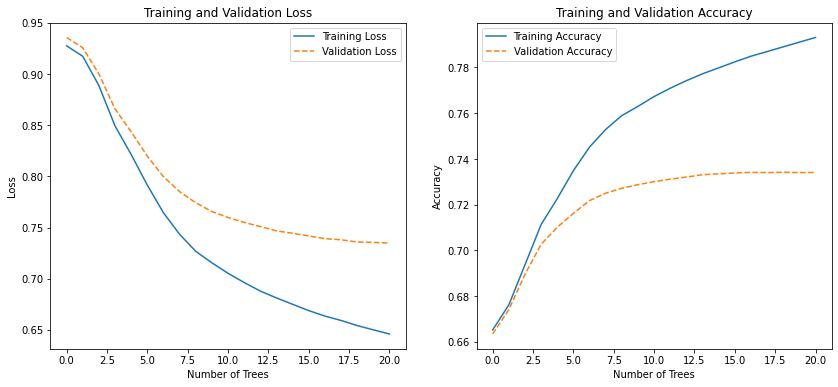

Accuracy for class 0 in GBDT: 90.58%
Accuracy for class 1 in GBDT: 55.45%
Accuracy for class 2 in GBDT: 36.80%
Accuracy for class 3 in GBDT: 33.05%
Overall Test Accuracy with GBDT: 0.7287596032767867
Overall Confusion Matrix with GBDT:
 [[38028  3009   794   150]
 [ 5614  9051  1513   146]
 [ 3002  2078  3328   635]
 [  813   260  1157  1101]]


In [59]:
# Plotting training and validation loss and accuracy curves
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


# Step 7: Evaluate on the test set

# Make predictions on test data for each model3 and column
y_test_pred_gbdt = np.column_stack([model3.predict(X_test) for model3 in model3s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in GBDT: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with GBDT:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with GBDT:\n", cm_gbdt)

In [81]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

# 假设 X_train 和 y_train 已定义
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=46)

# 参数网格
learning_rates = [0.1, 0.05, 0.005, 0.0005]
min_child_samples_list = [1, 5, 10]
max_depth_list = [5, 10]

# 初始化存储结果的列表
results = []

# 遍历所有参数组合
for lr in learning_rates:
    for min_child_samples in min_child_samples_list:
        for max_depth in max_depth_list:
            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []
            best_model3s = []
            best_iteration = 0
            best_val_loss = float("inf")
            best_rmse = float("inf")  # 初始化最佳 RMSE

            for i in tqdm(range(1, 101), desc=f"Training with lr={lr}, min_child_samples={min_child_samples}, max_depth={max_depth}"):
                column_train_losses, column_val_losses = [], []
                column_train_accuracies, column_val_accuracies = [], []
                column_rmses = []
                column_model3s = []

                for col in range(y_train.shape[1]):
                    model = LGBMClassifier(
                        n_estimators=i,
                        max_depth=max_depth,
                        learning_rate=lr,
                        min_child_samples=min_child_samples,
                        random_state=46,
                        device='gpu',
                        gpu_platform_id=1, 
                        gpu_device_id=0, 
                        verbose=-1
                    )
                    
                    model.fit(X_train, y_train.iloc[:, col])
                    
                    y_train_pred_proba = model.predict_proba(X_train)
                    y_val_pred_proba = model.predict_proba(X_val)
                    y_train_pred = model.predict(X_train)
                    y_val_pred = model.predict(X_val)

                    train_loss = log_loss(y_train.iloc[:, col], y_train_pred_proba)
                    val_loss = log_loss(y_val.iloc[:, col], y_val_pred_proba)
                    train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
                    val_acc = accuracy_score(y_val.iloc[:, col], y_val_pred)

                    # 计算RMSE
                    rmse = mean_squared_error(y_val.iloc[:, col], y_val_pred, squared=False)

                    column_train_losses.append(train_loss)
                    column_val_losses.append(val_loss)
                    column_train_accuracies.append(train_acc)
                    column_val_accuracies.append(val_acc)
                    column_rmses.append(rmse)
                    column_model3s.append(model)

                avg_train_loss = np.mean(column_train_losses)
                avg_val_loss = np.mean(column_val_losses)
                avg_train_acc = np.mean(column_train_accuracies)
                avg_val_acc = np.mean(column_val_accuracies)
                avg_rmse = np.mean(column_rmses)

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)
                train_accuracies.append(avg_train_acc)
                val_accuracies.append(avg_val_acc)

                # 更新最佳模型
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_rmse = avg_rmse
                    best_model3s = column_model3s
                    best_iteration = i

                # 提前停止条件
                if i > 10:
                    loss_drops = [val_losses[-j] - val_losses[-j-1] for j in range(1, 11)]
                    acc_improvements = [val_accuracies[-j] - val_accuracies[-j-1] for j in range(1, 11)]
                    
                    if all(drop < 0.0001 for drop in loss_drops) or all(improvement < 0.0001 for improvement in acc_improvements):
                        print(f"Early stopping at iteration {i}")
                        break

            # 将最佳结果添加到结果列表
            results.append({
                "learning_rate": lr,
                "min_child_samples": min_child_samples,
                "max_depth": max_depth,
                "best_iteration": best_iteration,
                "best_val_loss": best_val_loss,
                "best_rmse": best_rmse
            })

# 将结果保存到CSV文件
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results.csv", index=False)
print("所有结果已保存到 model_comparison_results.csv 文件中")


Training with lr=0.1, min_child_samples=1, max_depth=5:  10%|█         | 10/100 [01:21<12:17,  8.19s/it]


Early stopping at iteration 11


Training with lr=0.1, min_child_samples=1, max_depth=10:  10%|█         | 10/100 [02:01<18:10, 12.11s/it]


Early stopping at iteration 11


Training with lr=0.1, min_child_samples=5, max_depth=5:  10%|█         | 10/100 [01:25<12:51,  8.58s/it]


Early stopping at iteration 11


Training with lr=0.1, min_child_samples=5, max_depth=10:  10%|█         | 10/100 [02:08<19:12, 12.81s/it]


Early stopping at iteration 11


Training with lr=0.1, min_child_samples=10, max_depth=5:  10%|█         | 10/100 [01:21<12:15,  8.17s/it]


Early stopping at iteration 11


Training with lr=0.1, min_child_samples=10, max_depth=10:  10%|█         | 10/100 [02:24<21:40, 14.45s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=1, max_depth=5:  10%|█         | 10/100 [01:21<12:12,  8.14s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=1, max_depth=10:  10%|█         | 10/100 [02:05<18:52, 12.58s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=5, max_depth=5:  10%|█         | 10/100 [01:29<13:29,  9.00s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=5, max_depth=10:  10%|█         | 10/100 [02:06<18:58, 12.65s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=10, max_depth=5:  10%|█         | 10/100 [01:22<12:19,  8.22s/it]


Early stopping at iteration 11


Training with lr=0.05, min_child_samples=10, max_depth=10:  10%|█         | 10/100 [01:58<17:48, 11.88s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=1, max_depth=5:  10%|█         | 10/100 [01:23<12:34,  8.39s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=1, max_depth=10:  10%|█         | 10/100 [02:02<18:21, 12.24s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=5, max_depth=5:  10%|█         | 10/100 [01:22<12:24,  8.27s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=5, max_depth=10:  10%|█         | 10/100 [01:59<17:59, 11.99s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=10, max_depth=5:  10%|█         | 10/100 [01:22<12:20,  8.23s/it]


Early stopping at iteration 11


Training with lr=0.005, min_child_samples=10, max_depth=10:  10%|█         | 10/100 [01:58<17:43, 11.81s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=1, max_depth=5:  10%|█         | 10/100 [01:21<12:12,  8.13s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=1, max_depth=10:  10%|█         | 10/100 [02:00<18:07, 12.09s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=5, max_depth=5:  10%|█         | 10/100 [01:22<12:24,  8.27s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=5, max_depth=10:  10%|█         | 10/100 [01:59<17:56, 11.96s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=10, max_depth=5:  10%|█         | 10/100 [01:23<12:32,  8.36s/it]


Early stopping at iteration 11


Training with lr=0.0005, min_child_samples=10, max_depth=10:  10%|█         | 10/100 [01:58<17:45, 11.84s/it]

Early stopping at iteration 11
所有结果已保存到 model_comparison_results.csv 文件中


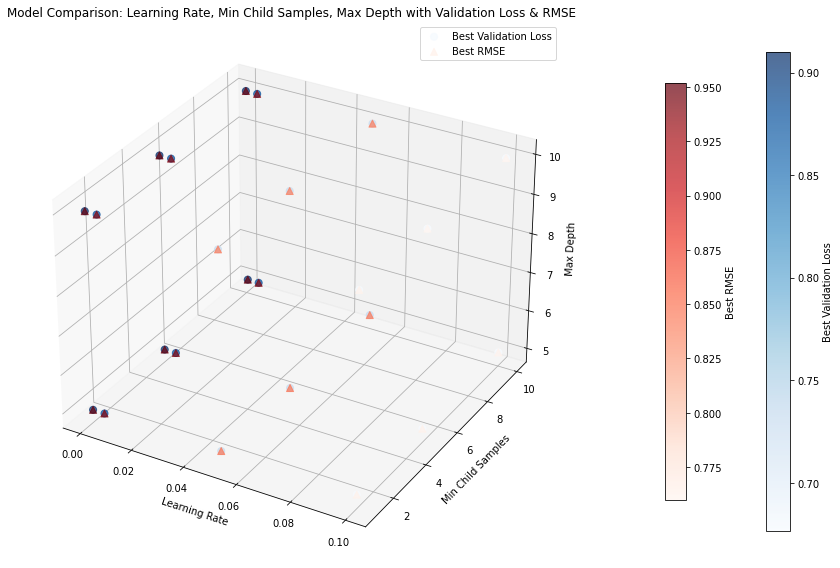

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 读取CSV文件
model_comparison_results = pd.read_csv('model_comparison_results.csv')

# 初始化3D图形
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制3D散点图，分别使用不同颜色表示best_val_loss和best_rmse
# 使用圆形标记表示best_val_loss
sc1 = ax.scatter(
    model_comparison_results['learning_rate'],
    model_comparison_results['min_child_samples'],
    model_comparison_results['max_depth'],
    c=model_comparison_results['best_val_loss'],  # 使用best_val_loss作为颜色
    s=50,  # 固定大小
    cmap='Blues',  # 蓝色映射表示best_val_loss
    marker='o',  # 圆形标记
    alpha=0.7,
    label='Best Validation Loss'
)

# 使用三角形标记表示best_rmse
sc2 = ax.scatter(
    model_comparison_results['learning_rate'],
    model_comparison_results['min_child_samples'],
    model_comparison_results['max_depth'],
    c=model_comparison_results['best_rmse'],  # 使用best_rmse作为颜色
    s=50,  # 固定大小
    cmap='Reds',  # 红色映射表示best_rmse
    marker='^',  # 三角形标记
    alpha=0.7,
    label='Best RMSE'
)

# 添加颜色条，分别对应best_val_loss和best_rmse
cbar1 = fig.colorbar(sc1, ax=ax, fraction=0.03, pad=0.1)
cbar1.set_label('Best Validation Loss')

cbar2 = fig.colorbar(sc2, ax=ax, fraction=0.03, pad=0.15)
cbar2.set_label('Best RMSE')

# 设置坐标轴标签
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Min Child Samples')
ax.set_zlabel('Max Depth')

# 设置标题和图例
plt.title('Model Comparison: Learning Rate, Min Child Samples, Max Depth with Validation Loss & RMSE')
ax.legend(loc='upper right')

plt.tight_layout()
# 保存3D图到PDF文件
plt.savefig('model_comparison_3d_plot.pdf')
plt.show()


In [88]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

# 读取参数比较结果文件
model_comparison_results = pd.read_csv('model_comparison_results.csv')

# 找到RMSE最小的参数组合
best_params = model_comparison_results.loc[model_comparison_results['best_rmse'].idxmin()]
best_learning_rate = best_params['learning_rate']
best_min_child_samples = int(best_params['min_child_samples'])
best_max_depth = int(best_params['max_depth'])

# 输出最优参数组合
print(f"最优参数组合：learning_rate={best_learning_rate}, min_child_samples={best_min_child_samples}, max_depth={best_max_depth}")

# 将数据集分为训练和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=46)

# 初始化存储训练和验证损失与准确率的列表
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_model3s = []  # 存储每个目标列的最佳模型
best_iteration = 0
best_val_loss = float("inf")

# 根据最优参数组合重新训练模型
for i in tqdm(range(1, 101), desc="Training Progress with Optimal Parameters"):
    column_train_losses, column_val_losses = [], []
    column_train_accuracies, column_val_accuracies = [], []
    column_model3s = []

    for col in range(y_train.shape[1]):
        # 使用最优参数初始化LightGBM模型
        model3 = LGBMClassifier(
            n_estimators=i,
            max_depth=best_max_depth,
            learning_rate=best_learning_rate,
            min_child_samples=best_min_child_samples,
            random_state=46,
            device='gpu',
            gpu_platform_id=1,
            gpu_device_id=0,
            verbose=-1
        )

        # 训练模型
        model3.fit(X_train, y_train.iloc[:, col])

        # 预测并计算训练和验证集的交叉熵损失与准确率
        y_train_pred_proba = model3.predict_proba(X_train)
        y_val_pred_proba = model3.predict_proba(X_val)
        y_train_pred = model3.predict(X_train)
        y_val_pred = model3.predict(X_val)

        train_loss = log_loss(y_train.iloc[:, col], y_train_pred_proba)
        val_loss = log_loss(y_val.iloc[:, col], y_val_pred_proba)
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        val_acc = accuracy_score(y_val.iloc[:, col], y_val_pred)

        # 存储每列的结果
        column_train_losses.append(train_loss)
        column_val_losses.append(val_loss)
        column_train_accuracies.append(train_acc)
        column_val_accuracies.append(val_acc)
        column_model3s.append(model3)

    # 计算平均损失与准确率
    avg_train_loss = np.mean(column_train_losses)
    avg_val_loss = np.mean(column_val_losses)
    avg_train_acc = np.mean(column_train_accuracies)
    avg_val_acc = np.mean(column_val_accuracies)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(avg_train_acc)
    val_accuracies.append(avg_val_acc)

    # 更新最佳模型
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model3s = column_model3s
        best_iteration = i

    # 早停条件
    if i > 20:
        loss_drops = [val_losses[-j] - val_losses[-j-1] for j in range(1, 11)]
        acc_improvements = [val_accuracies[-j] - val_accuracies[-j-1] for j in range(1, 11)]
        
        if all(drop < 0.0001 for drop in loss_drops) or all(improvement < 0.0001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

# 输出最佳迭代次数与验证损失
print(f"Best iteration: {best_iteration}, Best Validation Loss: {best_val_loss:.4f}")


最优参数组合：learning_rate=0.1, min_child_samples=5, max_depth=10


Training Progress with Optimal Parameters:  20%|██        | 20/100 [06:58<27:54, 20.94s/it]

Early stopping at iteration 21
Best iteration: 21, Best Validation Loss: 0.6562


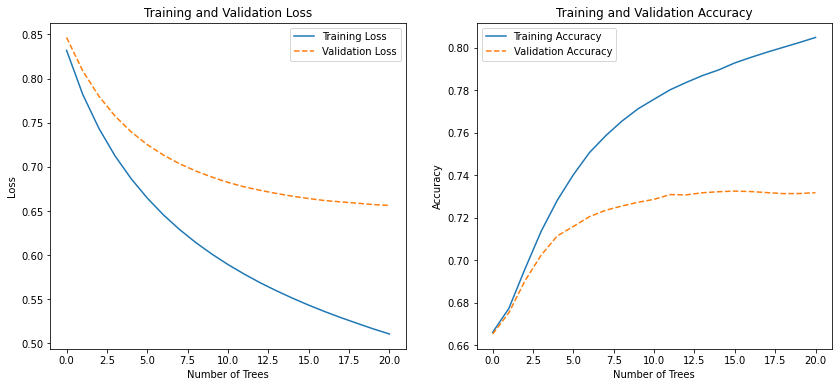

Accuracy for class 0 in LightGBM: 91.72%
Accuracy for class 1 in LightGBM: 55.13%
Accuracy for class 2 in LightGBM: 34.52%
Accuracy for class 3 in LightGBM: 31.13%
Overall Test Accuracy with LightGBM: 0.7309526167602824
Overall Confusion Matrix with LightGBM:
 [[38504  2768   581   128]
 [ 5820  9000  1359   145]
 [ 3275  2065  3122   581]
 [  937   240  1117  1037]]


In [91]:
# Plotting training and validation loss and accuracy curves
plt.figure(figsize=(14, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy", linestyle="--")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


# Step 7: Evaluate on the test set

# Make predictions on test data for each model3 and column
y_test_pred_gbdt = np.column_stack([model3.predict(X_test) for model3 in best_model3s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in LightGBM: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with LightGBM:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with LightGBM:\n", cm_gbdt)

In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize a dictionary to store RMSE for each class (0, 1, 2, 3)
class_rmse = {}

# For each class (0, 1, 2, 3), calculate RMSE across all columns
for class_label in [0, 1, 2, 3]:
    class_errors = []
    for col in range(y_test.shape[1]):
        # Get the true labels for the current column
        y_true_class = (y_test.iloc[:, col] == class_label).astype(int)
        
        # Get the predicted labels for the current column (convert predictions to binary for the specific class)
        y_pred_class = (y_test_pred_gbdt[:, col] == class_label).astype(int)

        # Calculate RMSE for the current class in the current column
        rmse = np.sqrt(mean_squared_error(y_true_class, y_pred_class))
        class_errors.append(rmse)
    
    # Calculate the average RMSE for the class across all columns
    class_rmse[class_label] = np.mean(class_errors)
    print(f"RMSE for class {class_label} across all columns: {class_rmse[class_label]:.4f}")

# Optional: Print a summary of RMSE for each class
print("\nRMSE by Class:")
for class_label, rmse in class_rmse.items():
    print(f"Class {class_label}: {rmse:.4f}")


RMSE for class 0 across all columns: 0.4316
RMSE for class 1 across all columns: 0.3688
RMSE for class 2 across all columns: 0.3494
RMSE for class 3 across all columns: 0.2096

RMSE by Class:
Class 0: 0.4316
Class 1: 0.3688
Class 2: 0.3494
Class 3: 0.2096


In [92]:
from sklearn.metrics import log_loss

# 初始化测试集的交叉熵损失列表
test_losses = []

# 遍历每个目标列，使用最佳模型对测试集进行预测
for col in range(y_test.shape[1]):
    # 使用最佳模型集合中的模型
    best_model = best_model3s[col]
    
    # 对测试集进行预测
    y_test_pred_proba = best_model.predict_proba(X_test)
    
    # 计算交叉熵损失
    test_loss = log_loss(y_test.iloc[:, col], y_test_pred_proba)
    test_losses.append(test_loss)

# 计算测试集平均交叉熵损失
avg_test_loss = np.mean(test_losses)

# 输出测试集的平均交叉熵损失
print(f"Test Set Average Cross-Entropy Loss: {avg_test_loss:.4f}")


Test Set Average Cross-Entropy Loss: 0.6525


In [ ]:
from sklearn.metrics import log_loss

# Calculate accuracy and cross-entropy for each column in the GBDT model
gbdt_accuracies = []
gbdt_cross_entropies = []

for col in range(y_test.shape[1]):
    # Get true and predicted values for the column
    col_true = y_test.iloc[:, col]
    col_pred = y_test_pred_gbdt[:, col]
    
    # Calculate accuracy
    accuracy = accuracy_score(col_true, col_pred)
    gbdt_accuracies.append(accuracy)
    
    # Calculate predicted probabilities using softmax probabilities for each class
    # Since GBDT does not provide direct softmax output, approximate class probabilities by assuming uniform for simplicity
    class_probs = np.zeros((len(col_pred), len(np.unique(y_test.values))))
    for i, class_value in enumerate(np.unique(col_pred)):
        class_probs[:, i] = (col_pred == class_value).astype(float)

    # Calculate cross-entropy loss (log loss)
    cross_entropy = log_loss(col_true, class_probs, labels=np.unique(y_test.values))
    gbdt_cross_entropies.append(cross_entropy)

# Create a DataFrame to store the results
gbdt_results_df = pd.DataFrame({
    'Column': [f'Column_{i+1}' for i in range(y_test.shape[1])],
    'Accuracy': gbdt_accuracies,
    'Cross_Entropy': gbdt_cross_entropies
})

# Save the results to a CSV file
gbdt_results_df.to_csv('lightgbm_model_metrics.csv', index=False)

# import ace_tools as tools; tools.display_dataframe_to_user(name="GBDT Model Metrics", dataframe=gbdt_results_df)


In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss

# Calculate accuracy and cross-entropy for each column in the GBDT model using predict_proba
gbdt_accuracies = []
gbdt_cross_entropies = []

for col in range(y_test.shape[1]):
    # Get true values for the column
    col_true = y_test.iloc[:, col]

    # Get predicted probabilities for the column using GBDT's predict_proba
    col_probs = best_model3s[col].predict_proba(X_test)

    # Ensure that the labels are aligned with the model's classes
    labels = best_model3s[col].classes_

    # Get predicted class labels based on probabilities
    col_pred = np.argmax(col_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(col_true, col_pred)
    gbdt_accuracies.append(accuracy)

    # Calculate cross-entropy loss (log loss) using the predicted probabilities
    cross_entropy = log_loss(col_true, col_probs, labels=labels)
    gbdt_cross_entropies.append(cross_entropy)

# Create a DataFrame to store the results
gbdt_results_df = pd.DataFrame({
    'Column': [f'Column_{i+1}' for i in range(y_test.shape[1])],
    'Accuracy': gbdt_accuracies,
    'Cross_Entropy': gbdt_cross_entropies
})

# Save the results to a CSV file
gbdt_results_df.to_csv('gbdt_model_metrics_updated.csv', index=False)

# # Display the results
# print("Metrics for each column saved to 'gbdt_model_metrics_updated.csv'")
# print(gbdt_results_df)


In [58]:
col_probs

array([[0.98210499, 0.01256731, 0.0053277 ],
       [0.9680624 , 0.02476699, 0.00717061],
       [0.93807574, 0.0529027 , 0.00902157],
       ...,
       [0.98093409, 0.01374456, 0.00532135],
       [0.92847356, 0.04896016, 0.02256628],
       [0.95741599, 0.03114487, 0.01143914]])

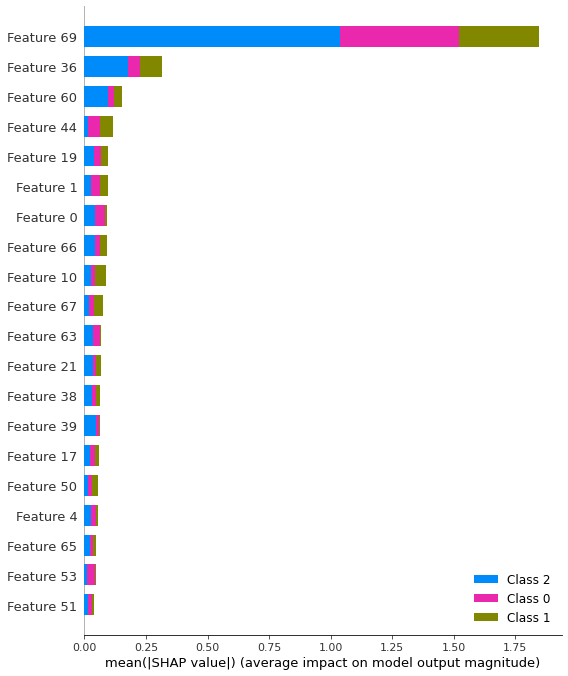

In [33]:
import shap
explainer_rf = shap.TreeExplainer(model3)  
shap_values_rf = explainer_rf.shap_values(X_test)  
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

d:\Anaconda\envs\tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


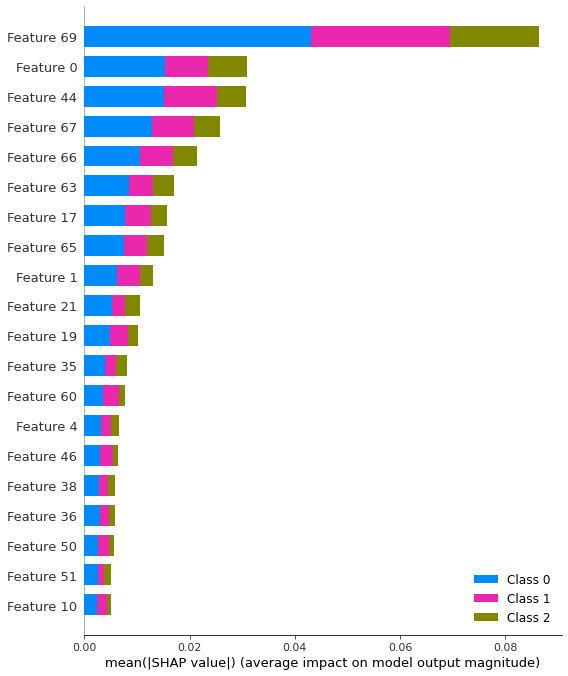

In [23]:
import shap
explainer_rf = shap.TreeExplainer(model)  
shap_values_rf = explainer_rf.shap_values(X_test)  
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")


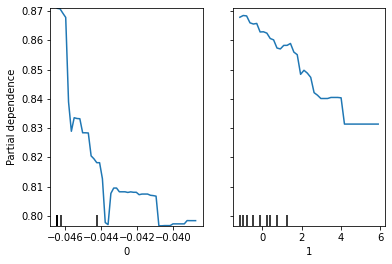

In [26]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_test, [0, 1], target=0, grid_resolution=50)
plt.show()

In [29]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, mode='classification')
exp_rf = explainer.explain_instance(X_test[0], model.predict_proba) 
exp_rf.show_in_notebook()


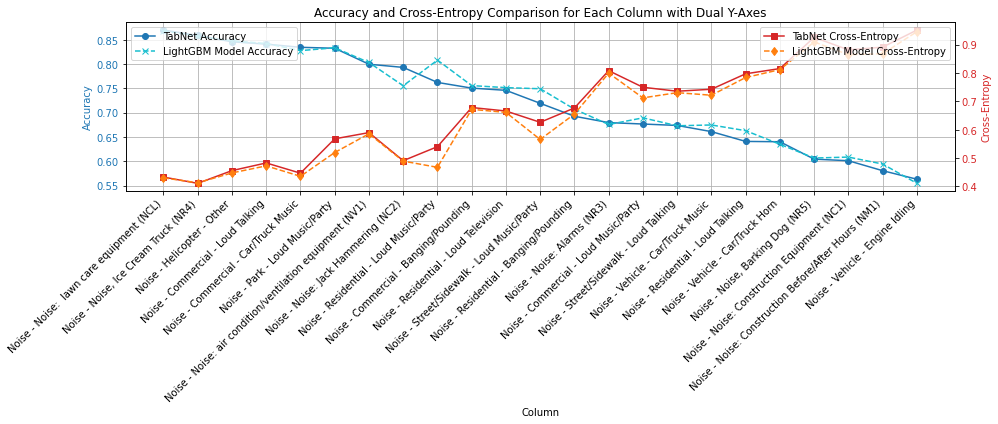

In [115]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV files
optimized_regression_model_metrics = pd.read_csv('optimized_regression_model_metrics.csv')
lightgbm_model_metrics = pd.read_csv('gbdt_model_metrics_updated.csv')

# replace the column names with the unique_types
optimized_regression_model_metrics['Column'] = unique_types
lightgbm_model_metrics['Column'] = unique_types

# Create a single figure with dual y-axes to plot accuracy and cross-entropy for each column, with rotated x-axis labels
fig, ax1 = plt.subplots(figsize=(14, 6))
# Sort the dataframes by TabNet Accuracy in descending order
optimized_regression_model_metrics.sort_values(by='Accuracy', ascending=False, inplace=True)
lightgbm_model_metrics = lightgbm_model_metrics.set_index('Column').reindex(optimized_regression_model_metrics['Column']).reset_index()

# Plot Accuracy Comparison for each column on the first y-axis
color1 = 'tab:blue'
ax1.set_xlabel('Column')
ax1.set_ylabel('Accuracy', color=color1)
ax1.plot(optimized_regression_model_metrics['Column'], optimized_regression_model_metrics['Accuracy'], label='TabNet Accuracy', marker='o', color=color1)
ax1.plot(lightgbm_model_metrics['Column'], lightgbm_model_metrics['Accuracy'], label='LightGBM Model Accuracy', marker='x', linestyle='--', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='upper left')
ax1.grid(True)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Create a second y-axis for Cross-Entropy
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Cross-Entropy', color=color2)
ax2.plot(optimized_regression_model_metrics['Column'], optimized_regression_model_metrics['Cross_Entropy'], label='TabNet Cross-Entropy', marker='s', color=color2)
ax2.plot(lightgbm_model_metrics['Column'], lightgbm_model_metrics['Cross_Entropy'], label='LightGBM Model Cross-Entropy', marker='d', linestyle='--', color='tab:orange')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='upper right')

# Set title
plt.title('Accuracy and Cross-Entropy Comparison for Each Column with Dual Y-Axes')

plt.tight_layout()
# save the plot into pdf file
plt.savefig('accuracy_cross_entropy_comparison.pdf')
plt.show()


In [111]:
unique_types

['Noise - Park - Loud Music/Party',
 'Noise - Residential - Loud Music/Party',
 'Noise - Street/Sidewalk - Loud Talking',
 'Noise - Vehicle - Car/Truck Music',
 'Noise - Helicopter - Other',
 'Noise - Residential - Banging/Pounding',
 'Noise - Street/Sidewalk - Loud Music/Party',
 'Noise - Commercial - Loud Music/Party',
 'Noise - Commercial - Loud Talking',
 'Noise - Residential - Loud Talking',
 'Noise - Vehicle - Car/Truck Horn',
 'Noise - Commercial - Banging/Pounding',
 'Noise - Noise: Construction Before/After Hours (NM1)',
 'Noise - Noise, Barking Dog (NR5)',
 'Noise - Noise: Jack Hammering (NC2)',
 'Noise - Residential - Loud Television',
 'Noise - Vehicle - Engine Idling',
 'Noise - Noise: Construction Equipment (NC1)',
 'Noise - Noise: Alarms (NR3)',
 'Noise - Noise: air condition/ventilation equipment (NV1)',
 'Noise - Noise:  lawn care equipment (NCL)',
 'Noise - Commercial - Car/Truck Music',
 'Noise - Noise, Ice Cream Truck (NR4)']